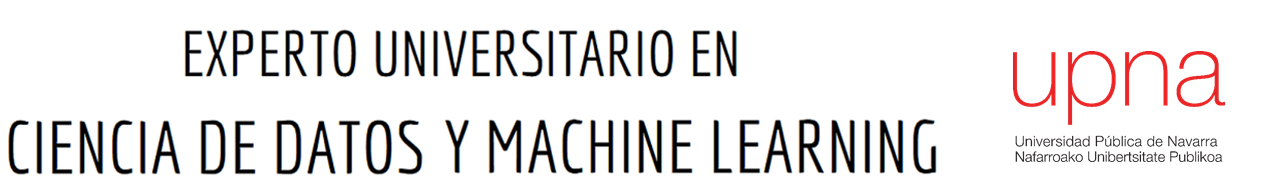

#### Módulo 2: Machine Learning Aplicado

# 25. Práctica: Mastering Random Forest y XGBoost

#### Contenidos:
* [25.1 Dataset](#1)
* [25.2 Mastering Random Forest](#2)
* [25.3 Mastering XGBoost](#3)
* [25.4 Pruebas libres adicionales](#4)

En este notebook vamos a poner en práctica lo aprendido sobre Random Forest y XGBoost de manera un poco más exhaustiva. Estudiaremos diferentes configuraciones de hiper-parámetros y veremos cómo optimizarlos. 

## 25.1. Dataset  <a class="anchor" id="1"></a>

Vamos a trabajar sobre uno de los problemas de clasificación tratados en la práctica anterior: Pima. Se trata de un dataset con 768 ejemplos en el que el objetivo es detectar si una mujer de al menos 21 años de edad de origen indio Pima padece diabetes o no. Para ello, se utilizan las siguientes 8 variables:

1. Embarazada = Número de veces embarazada
2. Plas = Concentración de glucosa en plasma a 2 horas en una prueba de tolerancia oral a la glucosa
3. Pres = Presión arterial diastólica (mm Hg)
4. Piel = Espesor del pliegue cutáneo del tríceps (mm)
5. Insu = Insulina sérica de 2 horas (mu U / ml)
6. Masa = Índice de masa corporal (peso en kg / (altura en m) ^ 2)
7. Pedi = Función del pedigrí de la diabetes
8. Edad = Edad (años)

La etiqueta de clase representa si la persona no tiene diabetes (probado_negativo) o si la persona tiene diabetes (probado_positivo).

Los datos los tenemos disponibles en la carpeta `25_mastering_RF_XGBoost_practica` y, como en la práctica anterior, podemos utilizar la función `lecturaDatos` del fichero python `leer_datasets.py` para leerlos.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from leer_datasets import lecturaDatos

# Definimos el nombre del dataset
dataset = 'Pima'

# Establecemos la ruta del train y el test
fileTr = 'data/25_mastering_RF_XGBoost_practica/' + dataset + '/' + dataset + '-5-2tra.dat'
fileTest = 'data/25_mastering_RF_XGBoost_practica/' + dataset + '/' + dataset + '-5-2tst.dat'

# Leemos los datos con lecturaDatos 
datosTr, _ = lecturaDatos(fileTr)
datosTest, _ = lecturaDatos(fileTest)

# Creamos los DataFrames de train y test
df_train_original = pd.DataFrame(data = datosTr.data, columns = datosTr.feature_names)
df_train_original['Target'] = datosTr.target

df_test = pd.DataFrame(data = datosTest.data, columns = datosTest.feature_names)
df_test['Target'] = datosTest.target

print('- Dataset {}:'.format(dataset))
print('\t Número de atributos: ', len(datosTr.feature_names))
print('\t Número de elementos de cada clase en train: {}, {}'.format(np.bincount(datosTr.target)[0], np.bincount(datosTr.target)[1]))
print('\t Número de elementos de cada clase en test: {}, {}'.format(np.bincount(datosTest.target)[0], np.bincount(datosTest.target)[1]))

- Dataset Pima:
	 Número de atributos:  8
	 Número de elementos de cada clase en train: 400, 214
	 Número de elementos de cada clase en test: 100, 54


El primer paso para empezar con los datos es realizar un análisis descriptivo de los mismos (EDA). 

En concreto, nos fijamos en que, si usamos la función `describe()` de Pandas, el valor mínimo de ciertas variables es 0. Pero en algunos casos, por su significado, ese valor no es posible. Por ejemplo, una persona no puede tener 0 de presión sanguínea.

Las variables con presencia de 0s erróneos son: ['Pres', 'Insu', 'Plas', 'Skin', 'Mass'].

Vamos a realizar una imputación de datos en las variables que tienen un valor 0 cuando no debería ser posible. 

Para ello, con el conjunto de entrenamiento, calculamos la media de los valores no nulos de esas variables e imputamos dichos valores en los ejemplos que tengan un 0. 
En cuanto al conjunto de test, realizamos la misma imputación pero utilizando los valores medios que hemos obtenido en el conjunto de train. 

In [16]:
df_train_original.describe()

df_train_corregido = df_train_original.copy()
df_test_corregido  = df_test.copy()

variables_con_ceros = ['Pres', 'Insu', 'Plas', 'Skin', 'Mass']

for variable in variables_con_ceros:
    mask = (df_train_corregido[variable] == 0)

    valor = np.mean(df_train_corregido.loc[np.logical_not(mask), variable])
    
    df_train_corregido.loc[mask, variable] = valor
    df_test_corregido.loc[mask, variable] = valor

## 25.2. Mastering Random Forest  <a class="anchor" id="2"></a>

Para trabajar con el ensemble Random Forest, vamos a utilizar la clases [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) de `sklearn.ensemble`. 

Para los propósitos de esta práctica, vamos a separar unos datos del conjunto de train con la intención de usarlos como conjunto de validación. Usa la función `train_test_split` para hacer esta separación. Usa 0.2 de `test_size` y 42 de `random_state`. 

In [17]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_train_corregido, test_size=0.2, random_state=42)
df_test = df_test_corregido

df_train.head()

,Preg,Plas,Pres,Skin,Insu,Mass,Pedi,Age,Target
83,4.0,90.0,88.0,47.0,54.000000,37.7,0.362,29.0,0
90,9.0,123.0,70.0,44.0,94.000000,33.1,0.374,40.0,0
227,4.0,151.0,90.0,38.0,158.775701,29.7,0.294,36.0,0
482,9.0,134.0,74.0,33.0,60.000000,25.9,0.460,81.0,0
464,5.0,106.0,82.0,30.0,158.775701,39.5,0.286,38.0,0


En esta práctica, vamos a ir modificando el valor de 7 de los citados hiper-parámetros de uno en uno y dibujaremos curvas de rendimiento del modelo para entender cómo afecta cada uno de ellos. Los 7 que vamos a tener en cuenta son: 
1. max_depth
2. min_samples_split
3. max_leaf_nodes
4. min_samples_leaf
5. n_estimators
6. max_samples
7. max_features

### 1. max_depth
Número entero para la profundidad de los árboles. Su valor por defecto es None, que indica que los nodos se expanden hasta que todas las hojas son puras o hasta que todas contienen menos de `min_samples_split` ejemplos.

Dibuja una gráfica evaluando el modelo en función del valor de este parámetro. En el eje X deben estar los valores del 2 al 50 y en el Y el F1-score. Se deben pintar la curva que describe el F1-score de train y de validación en la misma gráfica. 

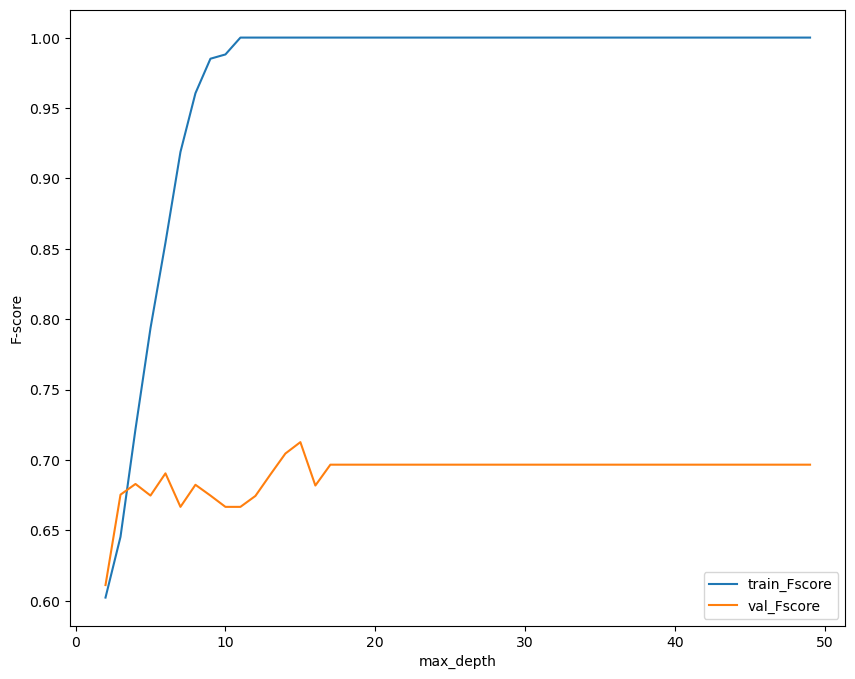

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

variables = datosTr.feature_names

plt.figure(figsize=(10,8))

depths = np.arange(2,50)
fscores_train = []
fscores_val = []


for i, param in enumerate(depths):
    RF = RandomForestClassifier(max_depth = param, random_state = 42)

    RF.fit(df_train[variables], df_train['Target'])
    pred_train = RF.predict(df_train[variables])
    pred_val = RF.predict(df_val[variables])
    
    fscores_train.append(f1_score(pred_train, df_train['Target']))
    
    fscores_val.append(f1_score(df_val['Target'], pred_val))

plt.plot(depths, fscores_train, label = 'train_Fscore')
plt.plot(depths, fscores_val, label = 'val_Fscore')  
plt.xlabel('max_depth')
plt.ylabel('F-score')
plt.legend()
plt.show()

Se observa que, conforme se aumenta la profundidad, los resultados de train mejoran pero los de test, después de mejorar al principio, empeoran rápidamente. Este hecho se debe al sobre-aprendizaje.

### 2. min_samples_split
Se trata del número mínimo de ejemplos que tiene que haber para poder dividir el nodo. Este parámetro admite un número entero, indicando el número exacto de ejemplos, o un float, indicando el porcentaje del número de ejemplos totales con el que queremos trabajar. Por defecto, toma el valor 2.

Dibuja una gráfica evaluando el modelo en función del valor de este parámetro. En el eje X deben estar los valores del 2 al 200 y en el Y el F1-score. Se deben pintar la curva que describe el F1-score de train y de validación en la misma gráfica. 

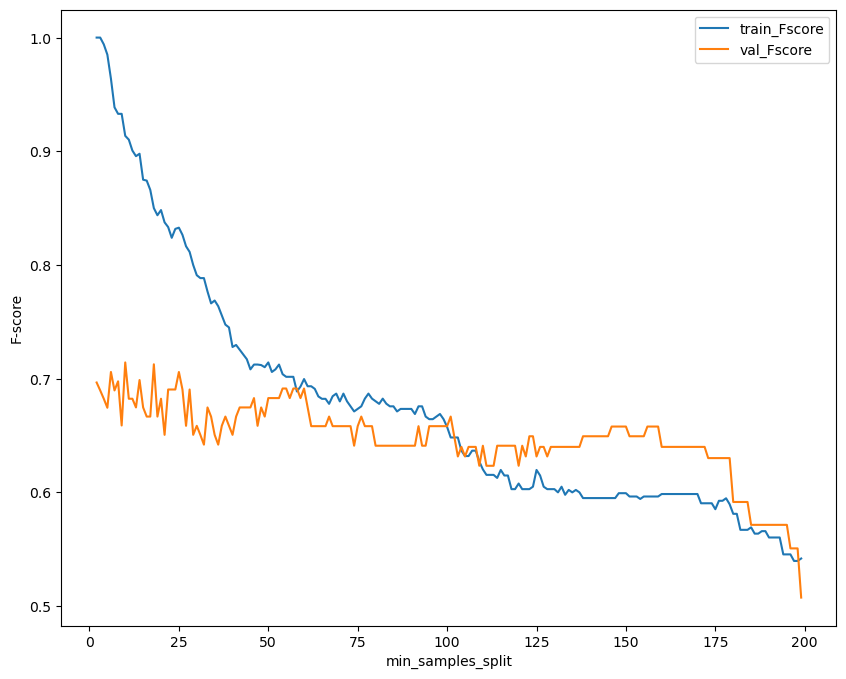

In [19]:
plt.figure(figsize=(10,8))

min_samples_split = np.arange(2,200)
fscores_train = []
fscores_val = []


for i, param in enumerate(min_samples_split):
    RF = RandomForestClassifier(min_samples_split = param, random_state = 42)

    RF.fit(df_train[variables], df_train['Target'])
    pred_train = RF.predict(df_train[variables])
    pred_val = RF.predict(df_val[variables])
    
    fscores_train.append(f1_score(pred_train, df_train['Target']))
    
    fscores_val.append(f1_score(df_val['Target'], pred_val))

plt.plot(min_samples_split, fscores_train, label = 'train_Fscore')
plt.plot(min_samples_split, fscores_val, label = 'val_Fscore') 
plt.xlabel('min_samples_split')
plt.ylabel('F-score')
plt.legend()
plt.show()

Al aumentar el valor del hiper-parámetro `min_samples_split`, podemos ver claramente que, para valores bajos, existe una diferencia considerable en el rendimiento en train y validación. Pero a medida que aumenta el valor del parámetro, la diferencia entre ambas disminuye.

Cuando el valor del parámetro aumenta demasiado, ambos rendimientos decrecen. Esto se debe al hecho de que el requisito mínimo para dividir un nodo es tan alto que no se observan divisiones significativas. Como resultado, tenemos un problema de bias alto.

### 3. max_leaf_nodes
El número, entero, de nodos hoja que se permiten como máximo. Por defecto toma el valor None, indicando que no hay restricción.

Dibuja una gráfica evaluando el modelo en función del valor de este parámetro. En el eje X deben estar los valores del 2 al 200 y en el Y el F1-score. Se deben pintar la curva que describe el F1-score de train y de validación en la misma gráfica. 

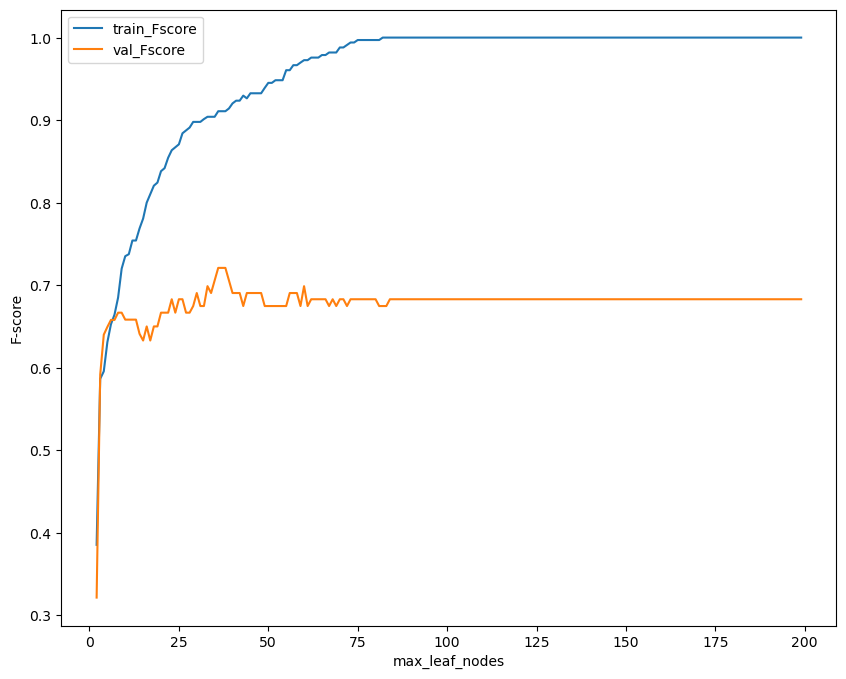

In [20]:
plt.figure(figsize=(10,8))

max_leaf_nodes = np.arange(2,200)
fscores_train = []
fscores_val = []


for i, param in enumerate(max_leaf_nodes):
    RF = RandomForestClassifier(max_leaf_nodes = param, random_state = 42)

    RF.fit(df_train[variables], df_train['Target'])
    pred_train = RF.predict(df_train[variables])
    pred_val = RF.predict(df_val[variables])
    
    fscores_train.append(f1_score(pred_train, df_train['Target']))
    
    fscores_val.append(f1_score(df_val['Target'], pred_val))

plt.plot(max_leaf_nodes, fscores_train, label = 'train_Fscore')
plt.plot(max_leaf_nodes, fscores_val, label = 'val_Fscore') 
plt.xlabel('max_leaf_nodes')
plt.ylabel('F-score')
plt.legend()
plt.show()

Podemos ver que cuando el valor del parámetro es pequeño, el árbol está desajustado y, a medida que aumenta el valor del parámetro, aumenta el rendimiento del árbol tanto en train como en validación. 

### 4. min_samples_leaf
El número mínimo de ejemplos que permitimos que haya en un nodo hoja. Admite números enteros o floats. 

Dibuja una gráfica evaluando el modelo en función del valor de este parámetro. En el eje X deben estar los valores del 1 al 100 y en el Y el F1-score. Se deben pintar la curva que describe el F1-score de train y de validación en la misma gráfica.

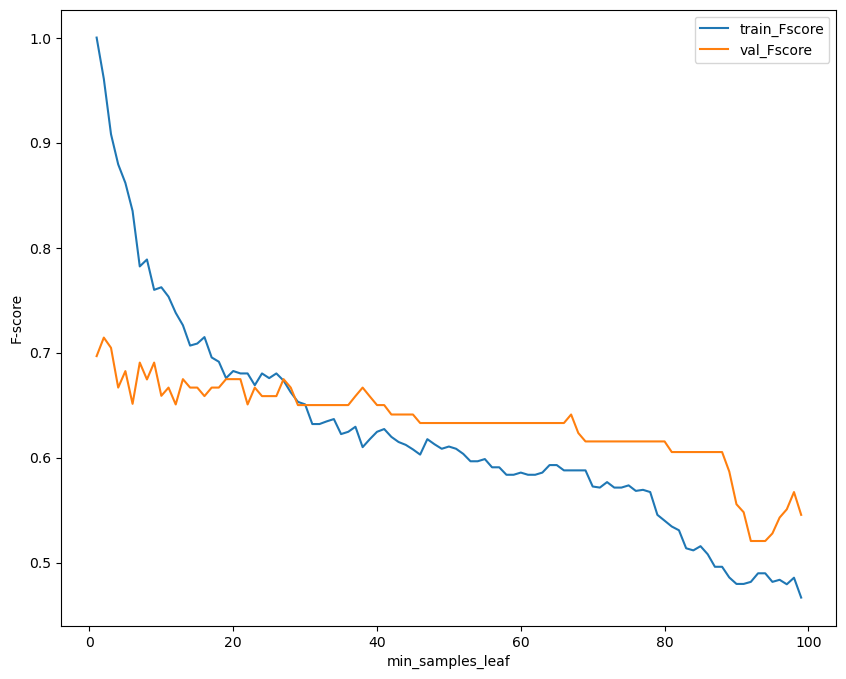

In [21]:
plt.figure(figsize=(10,8))

min_samples_leaf = np.arange(1,100)
fscores_train = []
fscores_val = []


for i, param in enumerate(min_samples_leaf):
    RF = RandomForestClassifier(min_samples_leaf = param, random_state = 42)

    RF.fit(df_train[variables], df_train['Target'])
    pred_train = RF.predict(df_train[variables])
    pred_val = RF.predict(df_val[variables])
    
    fscores_train.append(f1_score(pred_train, df_train['Target']))
    
    fscores_val.append(f1_score(df_val['Target'], pred_val))

plt.plot(min_samples_leaf, fscores_train, label = 'train_Fscore')
plt.plot(min_samples_leaf, fscores_val, label = 'val_Fscore') 
plt.xlabel('min_samples_leaf')
plt.ylabel('F-score')
plt.legend()
plt.show()

Podemos ver que el modelo Random Forest está sobreajustado cuando el valor del parámetro es muy bajo, en valores intermedios se corrige y para valores altos empiezan problemas de bias alto. 

### 5. n_estimators
Hasta ahora hemos visto hiper-parámetros propios de los estimadores base. Pasamos a ver los del ensemble. Este en concreto es el número de estimadores base del ensemble. Por defecto, 100. 

Dibuja una gráfica evaluando el modelo en función del valor de este parámetro. En el eje X deben estar los valores del 1 al 200 y en el Y el F1-score. Se deben pintar la curva que describe el F1-score de train y de validación en la misma gráfica.

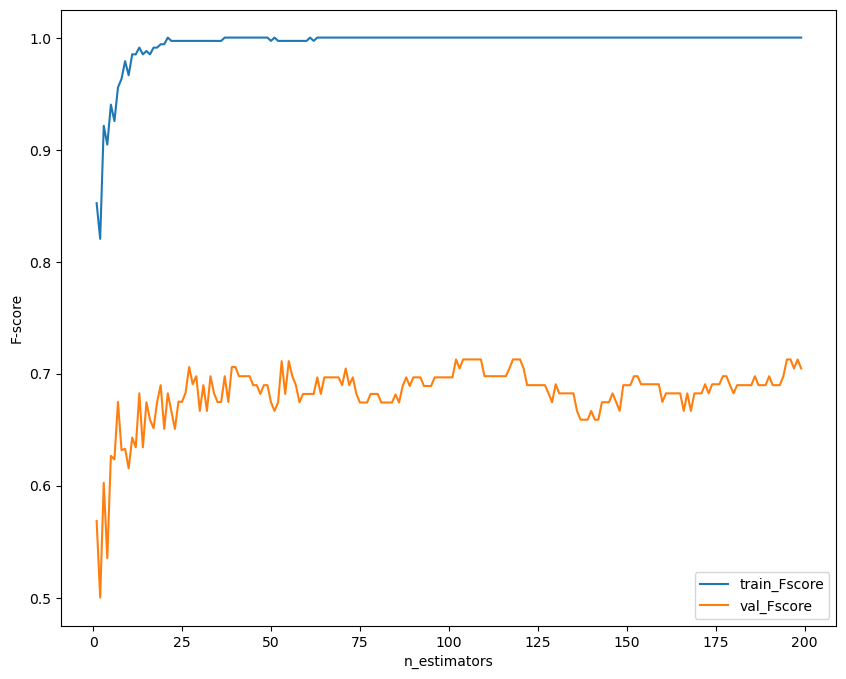

In [22]:
plt.figure(figsize=(10,8))

n_estimators = np.arange(1,200)
fscores_train = []
fscores_val = []


for i, param in enumerate(n_estimators):
    RF = RandomForestClassifier(n_estimators = param, random_state = 42)

    RF.fit(df_train[variables], df_train['Target'])
    pred_train = RF.predict(df_train[variables])
    pred_val = RF.predict(df_val[variables])
    
    fscores_train.append(f1_score(pred_train, df_train['Target']))
    
    fscores_val.append(f1_score(df_val['Target'], pred_val))

plt.plot(n_estimators, fscores_train, label = 'train_Fscore')
plt.plot(n_estimators, fscores_val, label = 'val_Fscore') 
plt.xlabel('n_estimators')
plt.ylabel('F-score')
plt.legend()
plt.show()

El rendimiento crece al principio y pasa a mantenerse estable. Por lo tanto, podemos deducir que para este problema no es indispensable utilizar una gran cantidad de estimadores base. 

### 6. max_samples
Es el número que indica el número de ejemplos que tendrá cada re-muestreo. Este parámetro admite un número entero, indicando el número exacto de ejemplos, o un float, indicando el porcentaje del número de ejemplos totales con el que queremos trabajar. Por defecto, 1.0: utilizamos tantos ejemplos en el re-muestreo como tenemos en el conjunto original.

Dibuja una gráfica evaluando el modelo en función del valor de este parámetro. En el eje X deben estar 50 valores reales entre 0.01 y 0.99 (np.linspace) y en el Y el F1-score. Se deben pintar la curva que describe el F1-score de train y de validación en la misma gráfica.

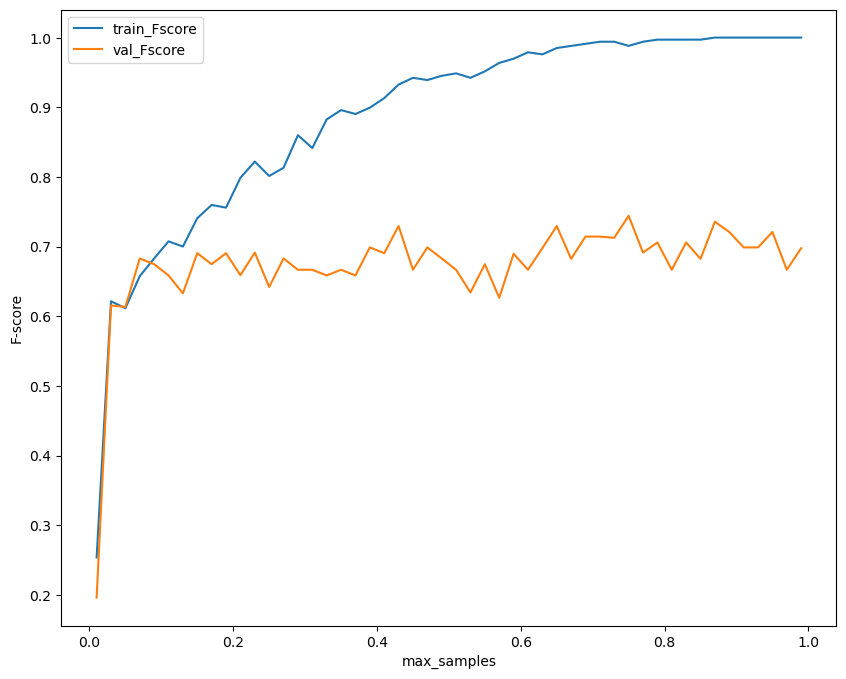

In [23]:
plt.figure(figsize=(10,8))

max_samples = np.linspace(0.01, 0.99, 50)
fscores_train = []
fscores_val = []


for i, param in enumerate(max_samples):
    RF = RandomForestClassifier(max_samples = param, random_state = 42)

    RF.fit(df_train[variables], df_train['Target'])
    pred_train = RF.predict(df_train[variables])
    pred_val = RF.predict(df_val[variables])
    
    fscores_train.append(f1_score(pred_train, df_train['Target']))
    
    fscores_val.append(f1_score(df_val['Target'], pred_val))

plt.plot(max_samples, fscores_train, label = 'train_Fscore')
plt.plot(max_samples, fscores_val, label = 'val_Fscore') 
plt.xlabel('max_samples')
plt.ylabel('F-score')
plt.legend()
plt.show()

El rendimiento crece rápido al principio y luego el error de validación se mantiene estable y el modelo se sobre-ajusta. La conclusión que sacamos es que no es necesario usar tantos ejemplos y se puede hacer un remuestreo de un número menor que el total de los datos para entrenar cada árbol. 

### 7. max_features
 El número de atributos que vamos a considerar en cada nodo. Admite los valores 'auto', 'sqrt', 'log2', un número entero, un float o None.
* 'auto': Es el valor por defecto e indica que el número de atributos en cada nodo sea la raíz cuadrada del número de atributos totales.
* 'sqrt': Como 'auto', indica que el número de atributos en cada nodo sea la raíz cuadrada del número de atributos totales.
* 'log2': Indica que el número de atributos en cada nodo sea el logaritmo en base 2 del número de atributos totales.
* Un número entero: Indica el número exacto de atributos. 
* Un float: Indica el porcentaje del número total de atributos que queremos utilizar en cada nodo. 
* None: Indica que el número de atributos sea igual que el número total de atributos.
    
Dibuja una gráfica evaluando el modelo en función del valor de este parámetro. En el eje X deben estar los valores del 1 al 8 y en el Y el F1-score. Se deben pintar la curva que describe el F1-score de train y de validación en la misma gráfica.    

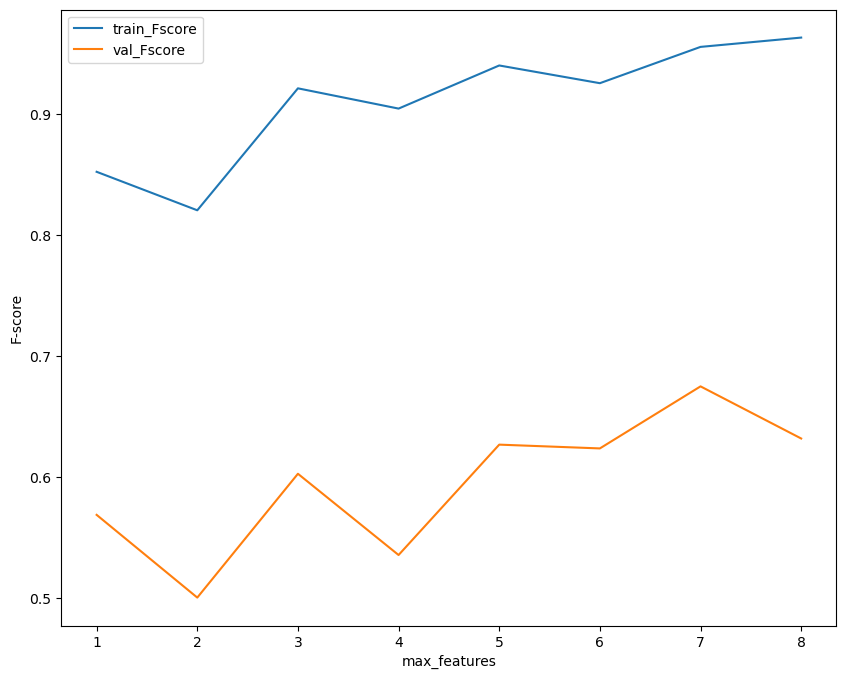

In [24]:
plt.figure(figsize=(10,8))

max_features = np.arange(1,9)
fscores_train = []
fscores_val = []


for i, param in enumerate(max_features):
    RF = RandomForestClassifier(n_estimators = param, random_state = 42)

    RF.fit(df_train[variables], df_train['Target'])
    pred_train = RF.predict(df_train[variables])
    pred_val = RF.predict(df_val[variables])
    
    fscores_train.append(f1_score(pred_train, df_train['Target']))
    
    fscores_val.append(f1_score(df_val['Target'], pred_val))

plt.plot(max_features, fscores_train, label = 'train_Fscore')
plt.plot(max_features, fscores_val, label = 'val_Fscore') 
plt.xlabel('max_features')
plt.ylabel('F-score')
plt.legend()
plt.show()

En este caso también el rendimiento de validación es mayor cuando no se utilizan todos los atributos. Esto indica que no es necesario utilizar todos, pudiendo llegar a sobre-ajustar el modelo.

### Grid-search sobre los parámetros estudiados

Hemos visto cuáles podrían ser los valores óptimos de cada parámetro por separado, pero los hiper-parámetros no son independientes entre sí. El valor de cada uno de ellos influye en el resto. Realizaremos un grid-search para ver si con los valores obtenidos podemos mejorar el rendimiento del clasificador. 

Aunque no lo hayamos estudiado de forma específica, se puede introducir en el grid-search el parámetro `criterion`, que indica el tipo de árbol de decisión que va a usar el ensemble como clasificador base. 

Realiza un grid-search sobre los parámetros estudiados para ver cuál es la mejor combinación de parámetros para este modelo en estos datos. Utiliza el conjunto de train original para hacer validación cruzada. Al final, reporta el rendimiento en el conjunto de test. 

Intenta obtener el mejor resultado posible!

**Nota:** Si hacemos varias pruebas es conveniente fijar el random_state a un número para poder reproducir resultados.

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

parameters = {'max_depth': [None],
              'criterion': ['gini','entropy'],
              'min_samples_split': [2, 10, 15],
              'max_leaf_nodes': [None],
              'min_samples_leaf': [1, 5],
              'n_estimators': [50, 100],
              'max_samples': [None,0.4, 0.7],
              'max_features': [4, 5]}

clf = GridSearchCV(estimator = RandomForestClassifier(random_state = 42), scoring = 'roc_auc', param_grid = parameters)

clf.fit(df_train_corregido[variables], df_train_corregido['Target'])
pred_test = clf.predict(df_test[variables])

print(classification_report(pred_test, df_test['Target']))


print(clf.best_params_)

              precision    recall  f1-score   support

           0       0.87      0.77      0.82       113
           1       0.52      0.68      0.59        41

    accuracy                           0.75       154
   macro avg       0.69      0.73      0.70       154
weighted avg       0.78      0.75      0.76       154

{'criterion': 'entropy', 'max_depth': None, 'max_features': 4, 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 50}


## 25.3. Mastering XGBoost  <a class="anchor" id="3"></a>

XGBoost viene de "Extreme Gradient Boosting". Se trata de una librería optimizada y distribuida para aplicar algoritmos de Gradient Boosting ([aquí](https://xgboost.readthedocs.io/en/latest/index.html) su documentación). Además de los detalles de implementación que hacen que ahorremos recursos y ganemos en rapidez, una de las ventajas de xgboost es que da la opción de aplicar varias técnicas de regularización que nos pueden ser de utilidad.

Para utilizar esta implementación con Python, deberemos instalar el paquete `xgboost`. 

**Nota:** Para esta práctica debemos actualizar la versión del paquete `xgboost` que tenemos en el entorno.

Vamos a enumerar los parámetros de XGBoost y a optimizarlos con el mismo dataset que hemos usado para Random Forest. 

En este [link](https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters) se puede encontrar una guía completa de los parámetros de este modelo, donde aparecen, además, sus valores por defecto. Muchos de ellos coinciden con los parámetros que vimos para Gradient Boosting. 

En general, el paquete xgboost es diferente al scikit-learn (por ejemplo los nombres de los parámetros varían). Sin embargo, existe un *wrapper* llamado XGBClassifier que imita las clases de scikit-learn, por lo que no se nos hará difícil usarlo. 

### Ajuste de parámetros

Los algoritmos como XGBoost tienen una gran cantidad de hiper-parámetros y optimizarlos no es una tarea fácil. No siempre se tiene tiempo ilimitado para realizar un grid-search de todos los parámetros simultáneamente, especialmente cuando trabajamos con datasets grandes, por lo tanto vamos a seguir otra metodología para ajustar los hiper-parámetros. 

Los parámetros que vamos a tener en cuenta para realizar el ajuste son:
* learning_rate 
* max_depth
* min_child_weight
* gamma
* subsample
* colsample_bytree
* reg_lambda
* reg_alpha

Para ajustarlos, seguiremos este esquema: 

1. Inicializamos el modelo y lo utilizamos como baseline. 
2. Comenzaremos ajustando la estructura de los árboles, con max_depth, min_child_weight.  
3. Una vez fijada la estructura, continuamos con los parámetros de sampleo de cada uno de los árboles (subsample y colsample_bytree).
4. Finalizamos con los parámetros que previenen el sobreaprendizaje (learning rate, gamma y los parámetros de regularización reg_lambda y reg_alpha).

El valor de los parámetros que vayamos obteniendo lo guardaremos en un diccionario `best_params` cuyas claves serán los nombres de los parámetros. 

Actualizamos el conjunto de datos e inicializamos el diccionario.

In [26]:
best_params = {}

#### Ajuste del número de estimadores

Al ser XGBoost un modelo aditivo, donde cada estimador aporta mejoras al anterior, para optimizar el número de estimadores que utilizamos vamos a utilizar una técnica denominada **early stopping**, que consiste en entrenar el modelo cada vez con un estimador más e ir comprobando el error de validación. Cuando haya habido cierto número (establecido de antemano) de iteraciones en el que el error de validación no ha decrecido, se detiene el entrenamiento. 

Esto nos va a servir para establecer el número óptimo de árboles para la configuración de hiper-parámetros que consideremos. 

La técnica early stopping se puede utilizar directamente con la clase `XGBClassifier`, especificando en el constructor el número de iteraciones en las que el error de validación no debe decrecer para parar mediante el parámetro `early_stopping_rounds`. Como conjuntos de train y validación utilizaremos la separación de train y val que hemos realizado para ajustar el Random Forest.

Cada vez que entrenemos el modelo, ya sea directamente o mediante GridSearchCV, deberemos especificar cuál es el conjunto de validación que empleamos para hacer early stopping.

#### 1. Inicializar el modelo

Comenzamos el modelo con los siguientes parámetros: 

xgb = XGBClassifier(early_stopping_rounds=10, use_label_encoder=False, eval_metric='logloss')

Entrenamos el modelo, especificando en el parámetro `eval_set` el conjunto de validación (`eval_set = [(Xval, yval)]`) y observamos el rendimiento en test. 

In [30]:
import xgboost as xgb 

xgboost = xgb.XGBClassifier(early_stopping_rounds=10, use_label_encoder=False, eval_metric='logloss')
xgboost.fit(df_train[variables], df_train['Target'], eval_set=[(df_val[variables], df_val['Target'])], verbose=False)
print(classification_report(xgboost.predict(df_test[variables]), df_test['Target']))

              precision    recall  f1-score   support

           0       0.81      0.76      0.79       106
           1       0.54      0.60      0.57        48

    accuracy                           0.71       154
   macro avg       0.67      0.68      0.68       154
weighted avg       0.72      0.71      0.72       154



#### 2. Ajustar los parámetros propios de los árboles

Esta tarea también la vamos a realizar en varios pasos. Empezamos por estos dos parámetros:

* `max_depth`: La máxima profundidad de los árboles. Mismo parámetro que en Gradient Boosting. A medida que crece, se incrementa la varianza. Valores típicos: 3-10. 

* `min_child_weight`: La suma mínima de los pesos de los ejemplos necesaria en una hoja. Si no se proporcionan pesos de los ejemplos, se considera que todos tienen el mismo. 

Realizamos un grid-search con los valores entre 3 y 10 para el primer parámetro y [8,9,10] para el segundo. Como scoring utilizamos el área bajo la curva ROC ('roc_auc'). Guardamos el valor que obtengamos en el diccionario `best_params` e introducimos el valor también en el modelo xgboost. 

In [31]:
parameters = {'max_depth': [3,4,5,8,9,10],
              'min_child_weight': [8,9,10]}

clf = GridSearchCV(estimator = xgboost, param_grid = parameters, scoring = 'roc_auc', cv=5)

clf.fit(df_train[variables], df_train['Target'], eval_set=[(df_val[variables], df_val['Target'])], verbose=False)

print(classification_report(clf.predict(df_test[variables]), df_test['Target']))
print(clf.best_params_)

best_params['max_depth'] = clf.best_params_['max_depth']
best_params['min_child_weight'] = clf.best_params_['min_child_weight']
xgboost.max_depth = best_params['max_depth']
xgboost.min_child_weight = best_params['min_child_weight']

              precision    recall  f1-score   support

           0       0.84      0.77      0.80       109
           1       0.54      0.64      0.59        45

    accuracy                           0.73       154
   macro avg       0.69      0.71      0.69       154
weighted avg       0.75      0.73      0.74       154

{'max_depth': 8, 'min_child_weight': 9}


#### 3. Ajustar los parámetros de sampleo

Los parámetros en los que nos fijamos ahora son: 
* `subsample`: Float que especifica la fracción de ejemplos con los que se aprenden los estimadores base. Valores típicos: 0.5-1.
* `colsample_bytree`: Float que especifica la fracción de atributos con los que se va a entrenar cada uno de los árboles. Similar al parámetro `max_features` de Gradient Boosting. También existe `colsample_bylevel`.

Los valores que vamos a probar para ambos parámetros son desde 0.1 a 1.0 (de 0.1 en 0.1).

In [32]:
parameters = {'subsample': [i/10.0 for i in range(1, 11)],
             'colsample_bytree': [i/10.0 for i in range(1, 11)]}

clf = GridSearchCV(estimator = xgboost, param_grid = parameters, scoring = 'roc_auc', cv=5)

clf.fit(df_train[variables], df_train['Target'], eval_set=[(df_val[variables], df_val['Target'])], verbose=False)


print(classification_report(clf.predict(df_test[variables]), df_test['Target']))
print(clf.best_params_)

best_params['subsample'] = clf.best_params_['subsample']
best_params['colsample_bytree'] = clf.best_params_['colsample_bytree']
xgboost.subsample = best_params['subsample']
xgboost.colsample_bytree = best_params['colsample_bytree']

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       108
           1       0.57      0.67      0.62        46

    accuracy                           0.75       154
   macro avg       0.71      0.73      0.72       154
weighted avg       0.77      0.75      0.76       154

{'colsample_bytree': 0.7, 'subsample': 0.9}


#### 3. Ajustar los parámetros que previenen el sobreaprendizaje

Como primer paso, vamos a ajustar el factor de aprendizaje. Utilizamos los valores [0.01, 0.05, 0.1, 0.3, 1, 10]. 

In [33]:
parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.3, 1, 10]}

clf = GridSearchCV(estimator = xgboost, param_grid = parameters, scoring = 'roc_auc', cv=5)

clf.fit(df_train[variables], df_train['Target'], eval_set=[(df_val[variables], df_val['Target'])], verbose=False)


print(classification_report(clf.predict(df_test[variables]), df_test['Target']))
print(clf.best_params_)
best_params['learning_rate'] = clf.best_params_['learning_rate']
xgboost.learning_rate = best_params['learning_rate']

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       108
           1       0.57      0.67      0.62        46

    accuracy                           0.75       154
   macro avg       0.71      0.73      0.72       154
weighted avg       0.77      0.75      0.76       154

{'learning_rate': 0.3}


Ahora vamos a fijarnos en el parámetro `gamma`:
* `gamma`: Umbral mínimo de la reducción del error al hacer la división de un nodo para poder llevar a cabo esa división. Por defecto, toma el valor 0. 

Realizamos un grid-search con 0 valores cogidos de forma uniforme entre 0.1 y 0.5.

In [34]:
parameters = {'gamma': [i/10 for i in range(1, 6)]}

clf = GridSearchCV(estimator = xgboost, param_grid = parameters, scoring = 'roc_auc', cv=5)

clf.fit(df_train[variables], df_train['Target'], eval_set=[(df_val[variables], df_val['Target'])], verbose=False)

print(classification_report(clf.predict(df_test[variables]), df_test['Target']))
print(clf.best_params_)
best_params['gamma'] = clf.best_params_['gamma']
xgboost.gamma = best_params['gamma']

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       108
           1       0.57      0.67      0.62        46

    accuracy                           0.75       154
   macro avg       0.71      0.73      0.72       154
weighted avg       0.77      0.75      0.76       154

{'gamma': 0.1}


Vamos a ajustar los parámetros propios de XGBoost que tienen que ver con la regularización:

* `reg_lambda`: Término de regularización L2. 

* `reg_alpha`: Término de regularización L1.

Vamos a probar los valores [0.01, 0.5, 1, 100] para `reg_lambda` y [1, 3, 5, 100] para `reg_alpha`.

In [36]:
parameters = {'reg_lambda': [1e-2, 0.5, 1, 100],
             'reg_alpha': [1, 3, 5, 100]}

clf = GridSearchCV(estimator = xgboost, param_grid = parameters, scoring = 'roc_auc', cv=5)

clf.fit(df_train[variables], df_train['Target'], eval_set=[(df_val[variables], df_val['Target'])], verbose=False)


print(classification_report(clf.predict(df_test[variables]), df_test['Target']))
print(clf.best_params_)

best_params['reg_lambda'] = clf.best_params_['reg_lambda']
best_params['reg_alpha'] = clf.best_params_['reg_alpha']
xgboost.reg_lambda = best_params['reg_lambda']
xgboost.reg_alpha = best_params['reg_alpha']

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       108
           1       0.59      0.70      0.64        46

    accuracy                           0.77       154
   macro avg       0.73      0.75      0.73       154
weighted avg       0.78      0.77      0.77       154

{'reg_alpha': 1, 'reg_lambda': 0.5}


¿Cuánto ha mejorado el accuracy desde el primero que hemos propuesto hasta este último?

Realiza las pruebas que consideres oportunas para mejorar la clasificación.

## 25.4. Pruebas libres adicionales <a class="anchor" id="4"></a>

Una vez estemos satisfechos con los resultados obtenidos en este dataset, es hora de escoger otro e intentar aplicar todo lo aprendido para conseguir un buen modelo. Una propuesta interesante es aplicar las técnicas de oversampling y undersampling estudiadas de forma conjunta a un ensemble para hacer predicciones en conjuntos de datos muy desbalanceados. En el siguiente [link](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview) hay una competición de Kaggle con un problema de clasificación binaria con esas características. 

